# Fine Tuning a pre-trained Deep CNN on a GPU machine

This session is inspired by [a blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) by François Chollet, the creator of the Keras library.

**WARNING**: the execution of notebook **requires a GPU** e.g. nvidia K80, GTX 980 or later with **at least 6GB of GPU RAM**.


For this session we are going to use the dataset of the [dogs-vs-cats](https://www.kaggle.com/c/dogs-vs-cats/data).

To download the data yourself, create a password-based account on Kaggle, then click on the download link of one of the data file **when you are logged-in in your browser** to get to the form that makes you accept the terms and conditions of that challenge.

Then in a shell session possibly on a server do the following:

```bash
pip install kaggle-cli
mkdir -p ~/data/dogs-vs-cats
cd ~/data/dogs-vs-cats
kg download -u username -p password -c dogs-vs-cats
```

This should download 3 files among which: `train.zip` and `test1.zip` (and a CSV template file we won't need).

If you have a problem in downloading the dataset using shell session, you can download it in Kaggle web site
https://www.kaggle.com/c/dogs-vs-cats/overview

Once this is done **we can extract the archives for the train set**:

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import os.path as op
import zipfile
import shutil
import pandas as pd

import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [2]:
myDir = op.expanduser('~\Desktop\M2\deepL\dogs-vs-cats')
trainDir = op.join(myDir, 'train')

In [3]:
trainDir

'C:\\Users\\Sami\\Desktop\\M2\\deepL\\dogs-vs-cats\\train'

The Keras image data helpers want images for different classes ('cat' and 'dog') to live in distinct subfolders. Let's rearrange the image files to follow that convention:

In [1]:
imgFiles = image_filenames = [op.join(trainDir, fn) for fn in os.listdir(trainDir)
                       if fn.endswith('.jpg')]

NameError: name 'os' is not defined

In [36]:
for files in imgFiles:
        subdirName, _ = files.split('.', 1)
        subdirName = op.join(trainDir, subdirName)
        if not op.exists(subdirName):
            os.mkdir(subdirName)
        shutil.move(files, subdirName)


Lets build a validation dataset by taking 500 images of cats and 500 images of dogs out of the training set:

In [37]:
nbVal = 500

validationDir = op.join(myDir, 'validation')
if not op.exists(validationDir):
    os.mkdir(validationDir)

In [ ]:
for animal in ['dog', 'cat']:
    train = op.join(trainDir, animal)
    val = op.join(validationDir, animal)
    
    if not op.exists(val):
        os.mkdir(val)
    
    imgFiles = os.listdir(train)
    
    for files in imgFiles[-nbVal:]:
        shutil.move(op.join(train, files),val)

## Data Loading and Data Augmentation


Let's use keras utilities to manually load the first image file of the cat folder. If keras complains about the missing "PIL" library, make sure to install it with one of the following commands:

```bash
conda install pillow

# or

pip install pillow
```

You might need to restart the kernel of this notebook to get Keras work.

In [41]:
#pip install pillow

from PIL import Image

imgCat = Image.open(op.join('C:\\Users\\Sami\\Desktop\\M2\\deepL\\dogs-vs-cats\\train', 'cat', 'cat.50.jpg'))

imgCat.show()

Keras provides tools to generate many variations from a single image: this is useful to augment the dataset with variants that should not affect the image label: a rotated image of a cat is an image of a cat.

Doing data augmentation at train time make neural networks ignore such label-preserving transformations and therefore help reduce overfitting.

The `ImageDataGenerator` object can the be pointed to the dataset folder both load the image and augment them on the fly and resize / crop them to fit the input dimensions of the classification neural network.

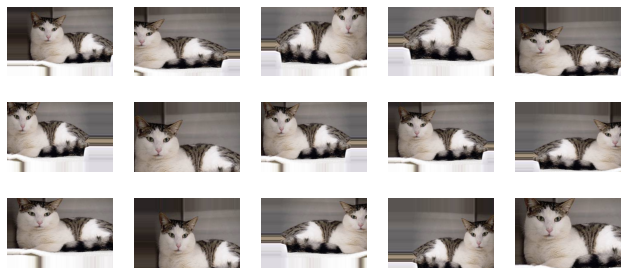

In [45]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

arrayCat =img_to_array(imgCat)

augmentTrain = ImageDataGenerator(

    rescale=1. / 255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

augmentVal= ImageDataGenerator(rescale=1./255)

plt.figure(figsize=(11, 5))
flow = augmentTrain.flow(arrayCat[np.newaxis, :, :, :])
for i, x_augmented in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_augmented[0])
    plt.axis('off')

## Loading a pre-trained computer vision model

Let us load a state of the art model with a good tradeoff between prediction speed, model size and predictive accuracy, namely a Residual Network with 54 parameterized layers (53 convolutional + 1 fully connected for the softmax):

In [ ]:
#pip install graphviz

In [51]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

Resmodel = ResNet50(weights='imagenet')

In [52]:
Resmodel.input_shape


(None, 224, 224, 3)

If you have `graphviz` system package and the `pydot_ng` python package installed you can display the structure of the network.

## Transfer learning

Let's remove the last dense classification layer that is specific to the image net classes and use the previous layer (after flattening) as a feature extractor:

In [96]:
output = Resmodel.layers[-2].output
base_model = Model(Resmodel.input, output)

When using this model we need to be careful to apply the same image processing as was used during the training, otherwise the marginal distribution of the input pixels might not be on the right scale:

In [56]:
def preprocess(x):
    if x.ndim == 3:
        x = x[np.newaxis, :, :, :]
    return preprocess_input(x)

dataAugmentation = ImageDataGenerator(preprocessing_function=preprocess)

In [85]:
trainFlow = dataAugmentation.flow_from_directory(
    trainDir,
    target_size=(224, 224),
    batch_size= 45,
    class_mode='binary',
    shuffle=True,
)

X, y = next(trainFlow)


Found 25000 images belonging to 2 classes.


In [84]:
print(X.shape, y.shape)

(45, 224, 224, 3) (45,)


**Exercise**: write a function that iterate of over 5000 images in the training set (bach after batch), extracts the activations of the last layer of `base_model` (by calling predicts) and collect the results in a big numpy array with dimensions `(5000, 2048)` for the features and `(5000,)` for the matching image labels.

In [92]:
def extract(model):
    features = []
    labels = []
    i = 0
    for X, y in trainFlow:
        labels.append(y)
        features.append(model.predict(X))
        i += len(y)
        if i >= 5000:
            break

    labels_final = np.concatenate(labels)
    features_final = np.vstack(features)
    return labels_final, features_final


In [94]:
lab, feat = extract(base_model)

Let's load precomputed features if available:

In [68]:
print(feat.shape)

(5040, 2048)


Let's train a simple linear model on those features. First let's check that the resulting small dataset has balanced classes:

Let's define the classification model:

In [87]:
model = Sequential()

Alright so the transfer learning is already at ~0.98 / 0.99 accuracy. This is not too surprising as the cats and dogs classes are already part of the imagenet label set.

Note that this is **already as good or slightly better than the winner of the original kaggle competition** [three years ago](https://www.kaggle.com/c/dogs-vs-cats/leaderboard). At that time they did not have pretrained resnet models at hand.

Or validation set has 1000 images, so an accuracy of 0.990 means only 10 classification errors.

Let's plug this on top the base model to be able to use it to make some classifications on our held out validation image folder:

Let's compute the validation score on the full validation set:

**Exercise:** display the example where the model makes the most confident mistakes.

To display images in jupyter notebook you can use:

```python
from IPython.display import Image, display
import os.path as op

display(Image(op.join(validation_folder, image_name)))
```

The filenames of items sampled by a flow (without random shuffling) can be accessed via: `val_flow.filenames`.

## Fine tuning

Let's identify the location of the residual blocks (merge by addition in a residual architecture):

[]

Let's fix the weights of the low level layers and fine tune the top level layers:

Let's fine tune a bit the top level layers to see if we can further improve the accuracy. Use the **nvidia-smi** command in a bash terminal on the server to monitor the GPU usage when the model is training.

**Bonus exercise**: train your own architecture from scratch using adam and data augmentation. Start with a small architecture first (e.g. 4 convolutions layers interleaved with 2 max pooling layers followed by a `Flatten` and two fully connected layers).

**Bonus exercise**: run this notebook on an instance with several GPUs (NC12 or NC24 instances on Azure) and try to speed up the training with: https://medium.com/@kuza55/transparent-multi-gpu-training-on-tensorflow-with-keras-8b0016fd9012